# Test the StarNet model

This notebook takes you through the steps of how to test a trained model on given test data sets.
Requirements:
* python packages: `numpy h5py pytorch matplotlib seaborn sklearn`
* data files:
    - test_data.h5
    - mean_and_std.npy
    - starnet_cnn.h5

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import time
from matplotlib import gridspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import TensorDataset, DataLoader

datadir = ""

**Obtain data for normalizing labels and define function to denormalize labels**

In [2]:
mean_and_std = np.load(datadir + 'mean_and_std.npy')
mean_labels = mean_and_std[0]
std_labels = mean_and_std[1]
num_labels = mean_and_std.shape[1]

def denormalize(lb_norm):
    return ((lb_norm*std_labels) + mean_labels)

**Define functions to obtain test data**

In [3]:
def get_data(filename):
    with h5py.File(datadir + filename, 'r') as f:
        spectra_array = f['spectrum'][:]
        ap_ids = f['Ap_ID'][:]
        labels_array = np.column_stack((f['TEFF'][:],f['LOGG'][:],f['FE_H'][:]))
        snr_array = f['combined_snr'][:]  
    return  (ap_ids, snr_array, spectra_array, labels_array)

**Load test data and model**

In [4]:
test_ap_ids, test_snr, test_spectra, test_labels = get_data('test_data.h5')
print('Test set contains '  + str(len(test_spectra))+' stars')

test_dataset = TensorDataset(torch.Tensor(test_spectra))
test_dataloader = DataLoader(test_dataset, batch_size=500)

Test set contains 21033 stars


**Create CNN and load model weights**

In [5]:
num_fluxes = test_spectra.shape[1]
num_labels = test_labels.shape[1]

# Number of filters used in the convolutional layers
num_filters = [4,16]

# Length of the filters in the convolutional layers
filter_length = 8

# Length of the maxpooling window 
pool_length = 4

# Number of nodes in each of the hidden fully connected layers
num_hidden = [256,128]

def compute_out_size(in_size, mod):
    """
    Compute output size of Module `mod` given an input with size `in_size`.
    """
    
    f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
    return f.size()[1:]

class StarNet(nn.Module):
    def __init__(self, num_fluxes, num_filters, filter_length, 
                 pool_length, num_hidden, num_labels):
        super().__init__()
        
        # Convolutional and pooling layers
        self.conv1 = nn.Conv1d(1, num_filters[0], filter_length)
        self.conv2 = nn.Conv1d(num_filters[0], num_filters[1], filter_length)
        self.pool = nn.MaxPool1d(pool_length, pool_length)
        
        # Determine shape after pooling
        pool_output_shape = compute_out_size((1,num_fluxes), 
                                             nn.Sequential(self.conv1, 
                                                           self.conv2, 
                                                           self.pool))
        
        # Fully connected layers
        self.fc1 = nn.Linear(pool_output_shape[0]*pool_output_shape[1], num_hidden[0])
        self.fc2 = nn.Linear(num_hidden[0], num_hidden[1])
        self.output = nn.Linear(num_hidden[1], num_labels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x


model = StarNet(num_fluxes, num_filters, filter_length, 
          pool_length, num_hidden, num_labels)

# Load model weights
model_filename =  os.path.join(datadir,'starnet_cnn.pth.tar')
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

**Predict on test set**

In [6]:
time1 = time.time()
test_predictions = []
with torch.no_grad():
    for i, x_batch in enumerate(test_dataloader, 0):
        test_predictions.append(denormalize(model(x_batch[0].unsqueeze(1)).data.numpy()))
test_predictions = np.concatenate(test_predictions)
print('%0.2f seconds to make %i predictions.' % (time.time()-time1, len(test_spectra)))

4.94 seconds to make 21033 predictions.


**Show residuals on test set label predictions**

In [7]:
# Some plotting variables for asthetics
%matplotlib inline
# Label names
label_names = ['$T_{\mathrm{eff}}$', '$\log(g)$', '$[Fe/H]$']

# Pipeline names
x_lab = 'ASPCAP'
y_lab = 'StarNet'

plt.rcParams['axes.facecolor']='white'
sns.set_style("ticks")
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/tmp/ipykernel_455354/617401028.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


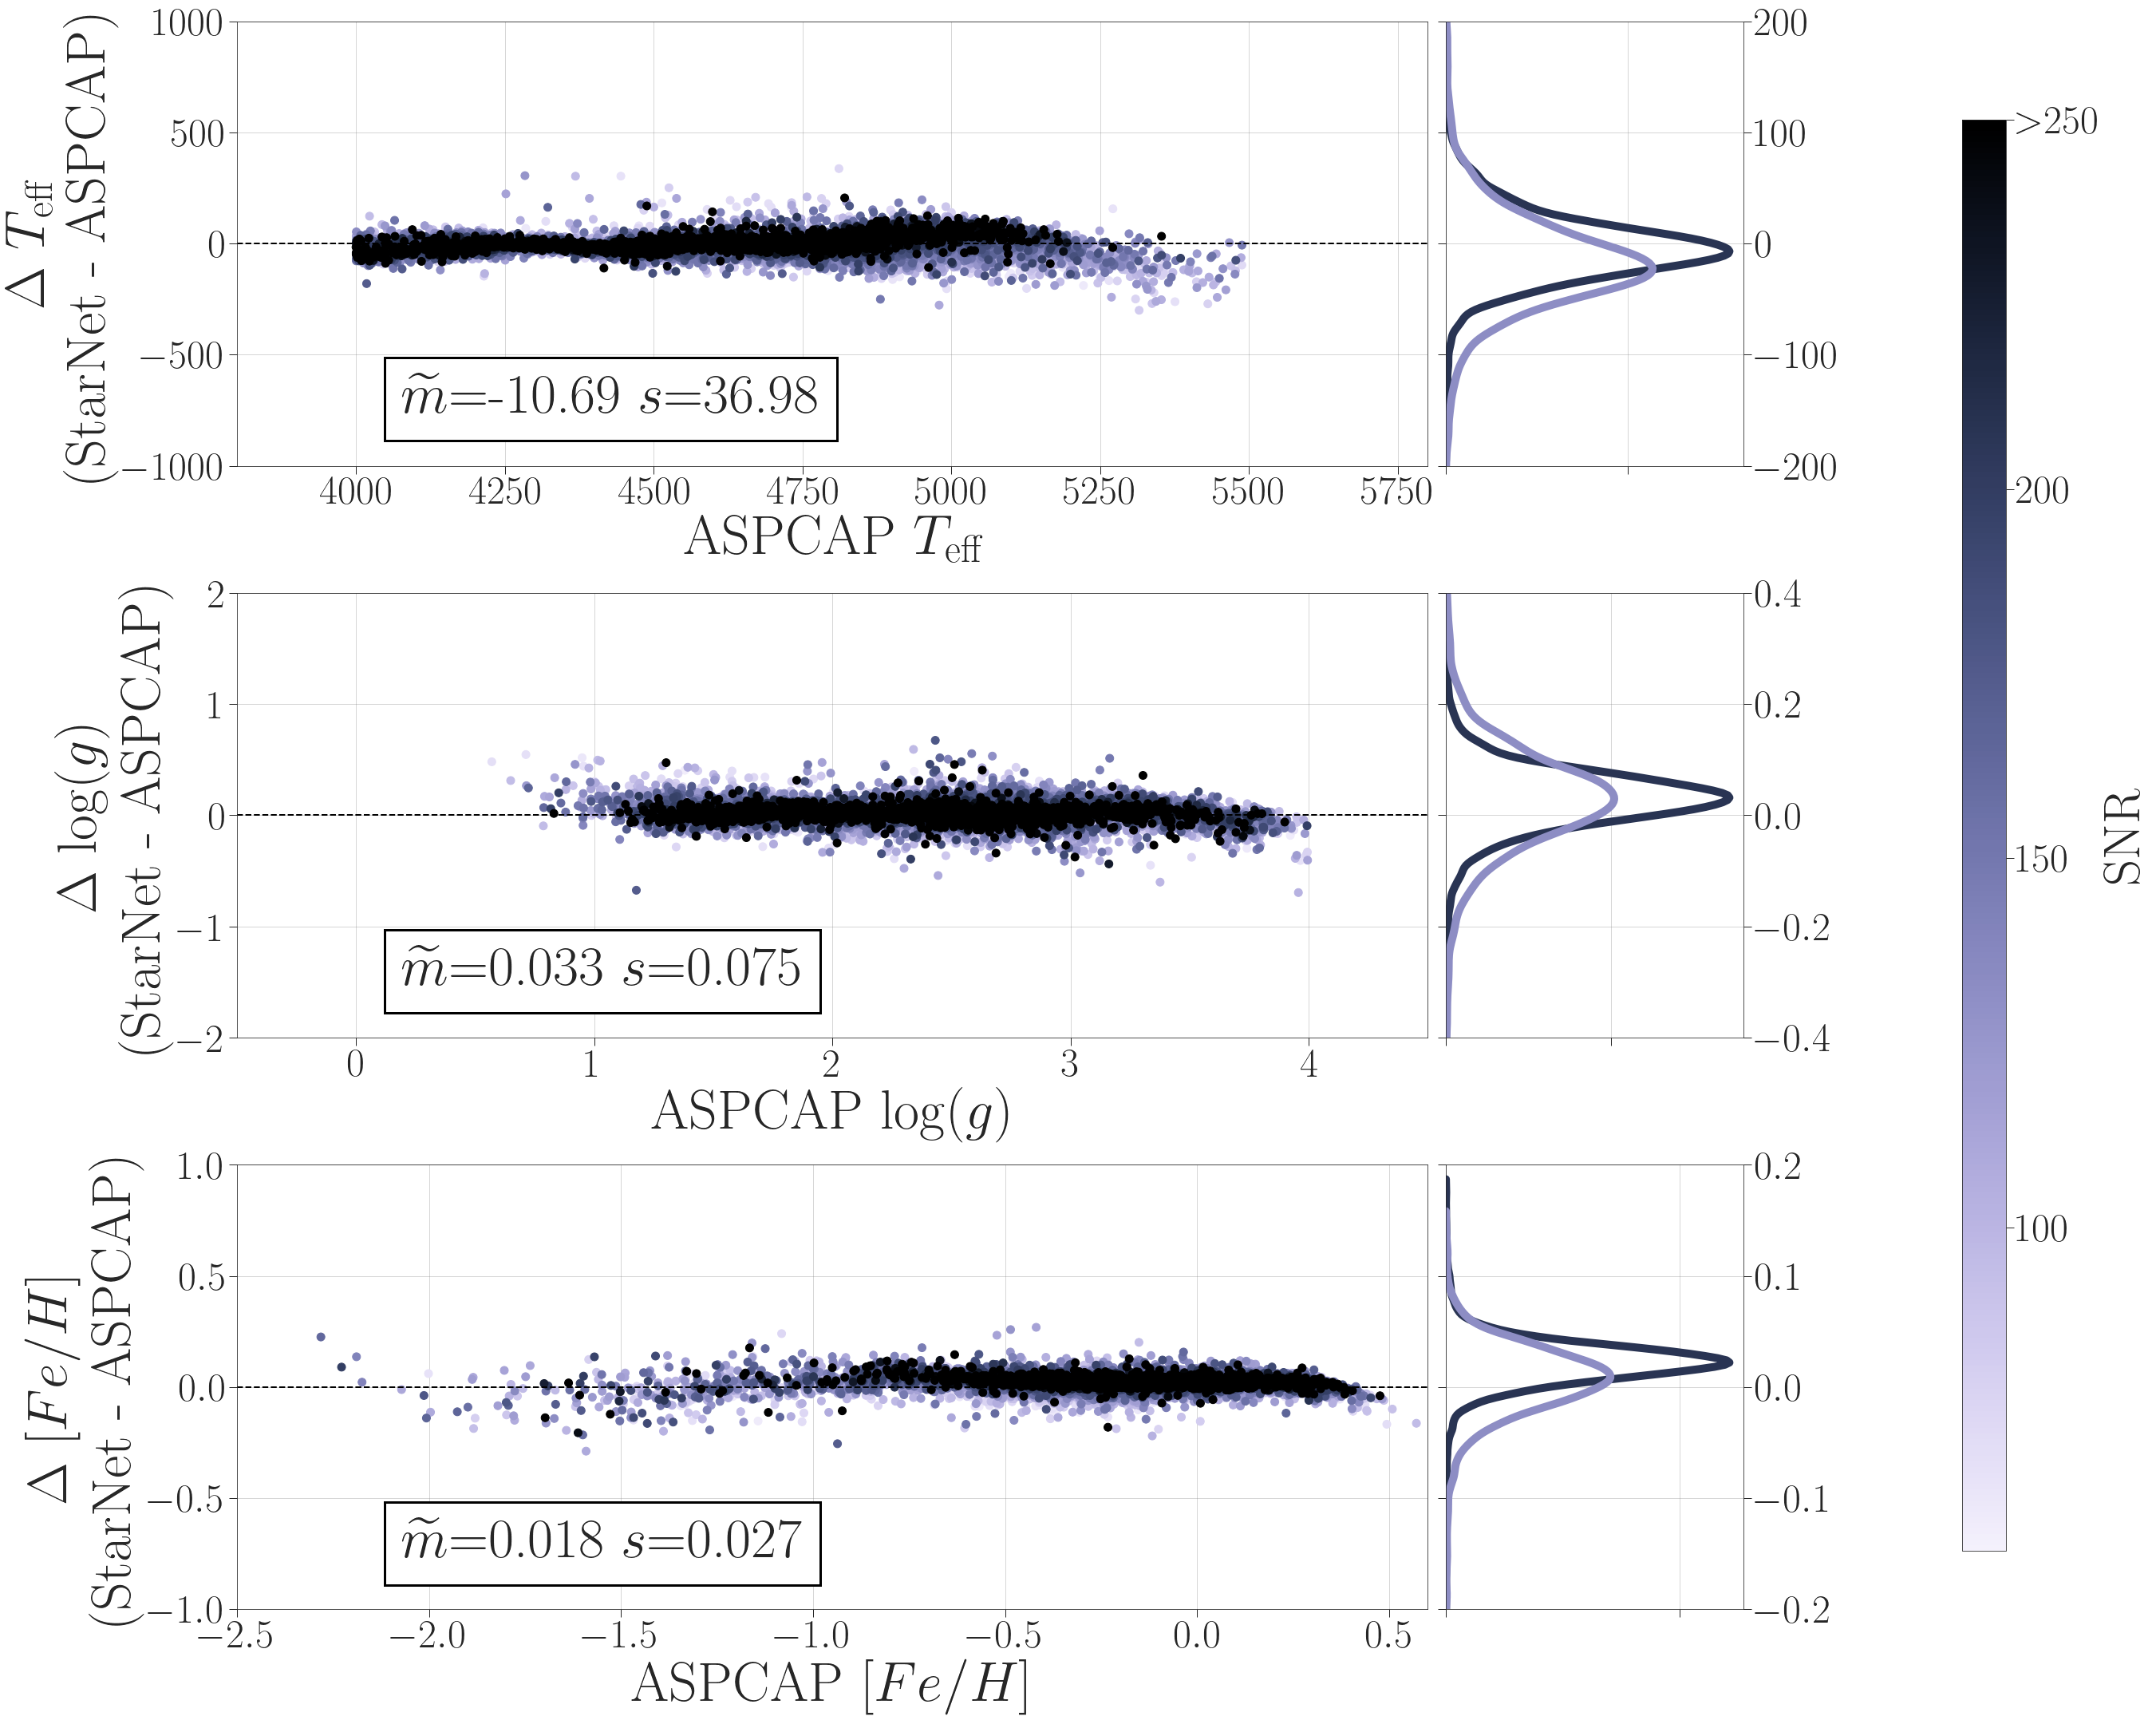

In [8]:
all_targets = test_labels
all_pred = test_predictions
z = test_snr
z[z>250]=250

resid = all_pred - all_targets

# Overplot high S/N
order = (z).reshape(z.shape[0],).argsort()
all_targets = all_targets[order]
resid = resid[order]
z = z[order,0]

bias = np.median(resid, axis=0)
scatter = np.std(resid, axis=0)

indices_a = np.where(z>=150)
indices_b = np.where(z<100)
resid_a = resid[indices_a,:]
resid_b = resid[indices_b,:]

cmap = sns.cubehelix_palette(8, start=2.8, rot=.1, dark=0, light=.95, as_cmap=True)

lims = [[(3800,5800),(-0.50,4.50),(-2.5,0.6)],[(-1000,1000),(-2.0,2.0),(-1.,1.)]]
ditribution_lims = [(-200,200),(-0.4,0.4),(-0.2,0.2)]

fig = plt.figure(figsize=(38, 30)) 
gs = gridspec.GridSpec(3, 2,  width_ratios=[4., 1])


for i in range(num_labels):

    ax0 = plt.subplot(gs[i,0])
    points = ax0.scatter(all_targets[:,i], resid[:,i], c=z, s=100, cmap=cmap)
    
    ax0.set_xlabel(x_lab + ' ' + label_names[i], fontsize=70)

    
    ax0.set_ylabel(r'$\Delta$ %s ' % (label_names[i]) +
                       '\n' + r'(%s - %s)' % (y_lab, x_lab), fontsize=70)
    
    ax0.tick_params(labelsize=50, width=1, length=10)
    ax0.set_xlim(lims[0][i])
    ax0.set_ylim(lims[1][i])
    ax0.plot([lims[0][i][0],lims[0][i][1]], [0,0], 'k--', lw=2)
 
    xmin, xmax = ditribution_lims[i]
    
    y_a = resid_a[0,:,i][(resid_a[0,:,i]>=xmin)&(resid_a[0,:,i]<=xmax)]
    y_b = resid_b[0,:,i][(resid_b[0,:,i]>=xmin)&(resid_b[0,:,i]<=xmax)]
    
    ax1 = plt.subplot(gs[i,1])
    a = sns.kdeplot(y=y_a, color=cmap(200), lw=10, ax=ax1)
    b = sns.kdeplot(y=y_b, color=cmap(100), lw=10, ax=ax1)
    
    a.set_ylim(ditribution_lims[i])
    b.set_ylim(ditribution_lims[i])
    
    ax1.tick_params(right=True, labelleft=False, 
                    labelright=True, labelbottom=False, 
                    labelsize=50, width=1, length=10)
    ax1.set_xlabel('')

    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=3)

    
    if i==0:
        plt.figtext(0.185, (1-((i*0.332)+0.24)),
                    '$\widetilde{m}$='+'{0:.2f}'.format(bias[i])+' $s$='+'{0:.2f}'.format(scatter[i]),
                    size=70, bbox=bbox_props)
    else:
        plt.figtext(0.185, (1-((i*0.332)+0.24)),
                    '$\widetilde{m}$='+'{0:.3f}'.format(bias[i])+' $s$='+'{0:.3f}'.format(scatter[i]),
                    size=70, bbox=bbox_props)

cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.83])
fig.colorbar(points,cax=cbar_ax)
cbar = fig.colorbar(points, cax=cbar_ax, extend='neither', spacing='proportional', orientation='vertical', format="%.0f")
cbar.set_label('SNR', size=65)
cbar.ax.tick_params(labelsize=50,width=1,length=10) 

cbar.set_ticks([100,150,200,250])
cbar.set_ticklabels(['100','150','200','$>$250'])

plt.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()